In [11]:
!pip install transformers accelerate peft datasets evaluate accelerate scikit-learn
!pip uninstall -y accelerate
!pip install accelerate==0.28.0


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Found existing installation: accelerate 0.28.0
Uninstalling accelerate-0.28.0:
  Successfully uninstalled accelerate-0.28.0


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached accelerate-0.28.0-py3-none-any.whl.metadata (18 kB)
Using cached accelerate-0.28.0-py3-none-any.whl (290 kB)


In [12]:
import torch, transformers, datasets, peft, evaluate, accelerate
print("Libraries loaded successfully")
print("Versions →")
print("Transformers:", transformers.__version__)
print("Datasets:", datasets.__version__)
print("Torch:", torch.__version__)
print("PEFT:", peft.__version__)
print("Evaluate:", evaluate.__version__)
print("Accelerate:", accelerate.__version__)


Libraries loaded successfully
Versions →
Transformers: 4.37.2
Datasets: 2.16.1
Torch: 2.9.0
PEFT: 0.10.0
Evaluate: 0.4.0
Accelerate: 0.28.0


In [13]:
import pandas as pd
from datasets import Dataset

def load_phrasebank(path: str):
    df = pd.read_csv(path)
    print("Raw shape:", df.shape)
    print(df.head(3))

    label2id = {"negative": 0, "neutral": 1, "positive": 2}
    id2label = {v: k for k, v in label2id.items()}
    df["labels"] = df["Sentiment"].map(label2id)

    ds = Dataset.from_pandas(df[["Sentence", "labels"]])
    return ds, label2id, id2label

ds_all, label2id, id2label = load_phrasebank("financial.csv")
print("Label mapping:", label2id)
print("Sample record:", ds_all[0])


Raw shape: (5842, 2)
                                            Sentence Sentiment
0  The GeoSolutions technology will leverage Bene...  positive
1  $ESI on lows, down $1.50 to $2.50 BK a real po...  negative
2  For the last quarter of 2010 , Componenta 's n...  positive
Label mapping: {'negative': 0, 'neutral': 1, 'positive': 2}
Sample record: {'Sentence': "The GeoSolutions technology will leverage Benefon 's GPS solutions by providing Location Based Search Technology , a Communities Platform , location relevant multimedia content and a new and powerful commercial model .", 'labels': 2}


In [14]:
# ============================================================
# 3. Train / Val / Test Split
# ============================================================
ds_split = ds_all.train_test_split(test_size=0.2, seed=42)
ds_train_val = ds_split["train"].train_test_split(test_size=0.1, seed=42)

ds_train = ds_train_val["train"]
ds_val   = ds_train_val["test"]
ds_test  = ds_split["test"]

print(f"Split complete | Train: {len(ds_train)} | Val: {len(ds_val)} | Test: {len(ds_test)}")


Split complete | Train: 4205 | Val: 468 | Test: 1169


In [15]:
# ============================================================
# 4. Tokenize Text
# ============================================================
from transformers import AutoTokenizer

model_name = "prajjwal1/bert-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)
max_length = 128

def tokenize_fn(batch):
    return tokenizer(
        batch["Sentence"],
        truncation=True,
        padding="max_length",
        max_length=max_length
    )

print("Tokenizing datasets...")
ds_train = ds_train.map(tokenize_fn, batched=True)
ds_val   = ds_val.map(tokenize_fn, batched=True)
ds_test  = ds_test.map(tokenize_fn, batched=True)
print("Tokenization done")

cols = ["input_ids", "attention_mask", "labels"]
for ds in [ds_train, ds_val, ds_test]:
    keep = {c for c in ds.column_names if c in cols}
    ds = ds.remove_columns([c for c in ds.column_names if c not in keep])
    ds.set_format(type="torch", columns=cols)

print("Data ready for PyTorch. Example:")
print(ds_train[0])


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Tokenizing datasets...


Map:   0%|          | 0/4205 [00:00<?, ? examples/s]

Map:   0%|          | 0/468 [00:00<?, ? examples/s]

Map:   0%|          | 0/1169 [00:00<?, ? examples/s]

Tokenization done
Data ready for PyTorch. Example:
{'Sentence': 'Sales in Finland decreased by 10.5 % in January , while sales outside Finland dropped by 17 % .', 'labels': 1, 'input_ids': [101, 4341, 1999, 6435, 10548, 2011, 2184, 1012, 1019, 1003, 1999, 2254, 1010, 2096, 4341, 2648, 6435, 3333, 2011, 2459, 1003, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [16]:
# ============================================================
# 5. Model & Metrics
# ============================================================
from transformers import AutoModelForSequenceClassification
import numpy as np
from sklearn.metrics import f1_score

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
)
print("Model loaded:", model_name)

import evaluate
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    preds, labels = eval_pred

    # Convert any scalars to arrays
    preds = np.array(preds).flatten().tolist()
    labels = np.array(labels).flatten().tolist()

    # Compute metrics
    acc = metric.compute(predictions=preds, references=labels)["accuracy"]
    f1 = f1_score(labels, preds, average="macro")

    return {"accuracy": acc, "f1_macro": f1}

print("Metric function ready")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-small and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded: prajjwal1/bert-small
Metric function ready


In [ ]:
# ============================================================
# 6. Fine-Tuning Loop (with tracking)
# ============================================================

import torch
from torch.utils.data import DataLoader
from transformers import AdamW, get_scheduler, DataCollatorWithPadding
from tqdm.auto import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

# --- Clean columns
keep_cols = ["input_ids", "attention_mask", "labels"]
def clean_dataset(ds):
    remove_cols = [c for c in ds.column_names if c not in keep_cols]
    ds = ds.remove_columns(remove_cols)
    ds.set_format(type="torch", columns=keep_cols)
    return ds

ds_train = clean_dataset(ds_train)
ds_val   = clean_dataset(ds_val)
ds_test  = clean_dataset(ds_test)

print("Columns after cleaning:")
print("Train:", ds_train.column_names)
print("Val:", ds_val.column_names)
print("Test:", ds_test.column_names)

# --- Loaders
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
train_loader = DataLoader(ds_train, batch_size=8, shuffle=True, collate_fn=data_collator)
val_loader   = DataLoader(ds_val, batch_size=16, collate_fn=data_collator)

# --- Optimizer & scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 3
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# --- Tracking containers
train_loss_history, val_loss_history = [], []
val_acc_history, val_f1_history = [], []

print("Starting manual fine-tuning...")
progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    avg_train_loss = total_loss / len(train_loader)
    train_loss_history.append(avg_train_loss)

    # --- Validation phase
    model.eval()
    val_loss = 0.0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            val_loss += outputs.loss.item()
            preds = torch.argmax(outputs.logits, dim=-1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch["labels"].cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    acc = accuracy_score(all_labels, all_preds)
    f1  = f1_score(all_labels, all_preds, average="macro")

    val_loss_history.append(avg_val_loss)
    val_acc_history.append(acc)
    val_f1_history.append(f1)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {acc:.4f} | Val F1: {f1:.4f}")

print("Training finished successfully.")

Columns after cleaning:
Train: ['labels', 'input_ids', 'attention_mask']
Val: ['labels', 'input_ids', 'attention_mask']
Test: ['labels', 'input_ids', 'attention_mask']
Starting manual fine-tuning...


  0%|          | 0/1578 [00:00<?, ?it/s]

In [ ]:
# ============================================================
# 7. Evaluate Model on Test Data
# ============================================================

from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from transformers import DataCollatorWithPadding
import numpy as np
import torch

# --- Build test loader
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
test_loader = DataLoader(ds_test, batch_size=16, collate_fn=data_collator)

model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# --- Collect predictions
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        preds = torch.argmax(outputs.logits, dim=-1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch["labels"].cpu().numpy())

# --- Compute metrics
acc = accuracy_score(all_labels, all_preds)
f1  = f1_score(all_labels, all_preds, average="macro")

print(f"Test Accuracy: {acc:.4f}, Test F1: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=list(label2id.keys())))
print("Confusion Matrix:\n", confusion_matrix(all_labels, all_preds))

# --- Save model
model.save_pretrained("final_full_model")
tokenizer.save_pretrained("final_full_model")
print("Model saved to 'final_full_model'")


Test Accuracy: 0.7425, Test F1: 0.6677

Classification Report:
              precision    recall  f1-score   support

    negative       0.40      0.37      0.38       178
     neutral       0.80      0.76      0.78       600
    positive       0.80      0.88      0.84       391

    accuracy                           0.74      1169
   macro avg       0.67      0.67      0.67      1169
weighted avg       0.74      0.74      0.74      1169

Confusion Matrix:
 [[ 66  87  25]
 [ 81 456  63]
 [ 18  27 346]]
Model saved to 'final_full_model'


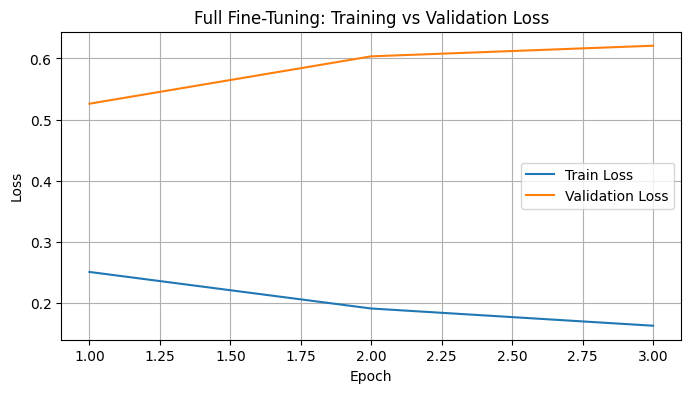

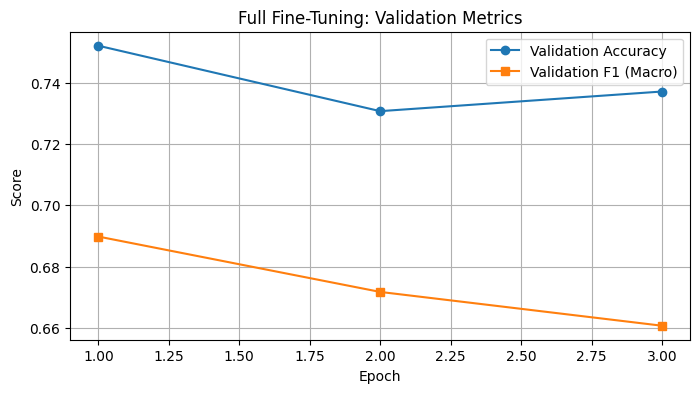

In [ ]:
# ============================================================
# 8. Visualize Full Fine-Tuning Metrics
# ============================================================

import matplotlib.pyplot as plt

epochs = range(1, len(train_loss_history) + 1)

# --- Plot training & validation loss
plt.figure(figsize=(8,4))
plt.plot(epochs, train_loss_history, label="Train Loss")
plt.plot(epochs, val_loss_history, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Full Fine-Tuning: Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# --- Plot validation accuracy and F1
plt.figure(figsize=(8,4))
plt.plot(epochs, val_acc_history, marker='o', label="Validation Accuracy")
plt.plot(epochs, val_f1_history, marker='s', label="Validation F1 (Macro)")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Full Fine-Tuning: Validation Metrics")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# ============================================================
# 9. LoRA Fine-Tuning Loop (with tracking)
# ============================================================

from peft import LoraConfig, get_peft_model, TaskType
from transformers import AdamW, get_scheduler, DataCollatorWithPadding
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import torch

# --- Configure LoRA
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    target_modules=["query", "value"],
)

# --- Load base model and wrap with LoRA
model_lora = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
)
model_lora = get_peft_model(model_lora, lora_config)
model_lora.print_trainable_parameters()

# --- Data and optimizer
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
train_loader = DataLoader(ds_train, batch_size=8, shuffle=True, collate_fn=data_collator)
val_loader   = DataLoader(ds_val,   batch_size=16, collate_fn=data_collator)

optimizer = AdamW(model_lora.parameters(), lr=2e-5)
num_epochs = 3
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_lora.to(device)

# --- Tracking containers
train_loss_lora, val_loss_lora = [], []
val_acc_lora, val_f1_lora = [], []

print("Starting LoRA fine-tuning...")
progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_epochs):
    model_lora.train()
    total_loss = 0.0
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model_lora(**batch)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    avg_train_loss = total_loss / len(train_loader)
    train_loss_lora.append(avg_train_loss)

    # --- Validation phase
    model_lora.eval()
    val_loss = 0.0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model_lora(**batch)
            val_loss += outputs.loss.item()
            preds = torch.argmax(outputs.logits, dim=-1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch["labels"].cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    acc = accuracy_score(all_labels, all_preds)
    f1  = f1_score(all_labels, all_preds, average="macro")

    val_loss_lora.append(avg_val_loss)
    val_acc_lora.append(acc)
    val_f1_lora.append(f1)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {acc:.4f} | Val F1: {f1:.4f}")

print("LoRA training finished successfully.")


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-small and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 67,075 || all params: 28,832,262 || trainable%: 0.23263870174320697
Starting LoRA fine-tuning...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/1578 [00:00<?, ?it/s]

Epoch 1 | Train Loss: 1.0193 | Val Loss: 0.9484 | Val Acc: 0.5491 | Val F1: 0.2612
Epoch 2 | Train Loss: 0.9343 | Val Loss: 0.9211 | Val Acc: 0.5598 | Val F1: 0.2725
Epoch 3 | Train Loss: 0.9212 | Val Loss: 0.9134 | Val Acc: 0.5641 | Val F1: 0.2847
LoRA training finished successfully.


In [ ]:
# ============================================================
# 10. Evaluate LoRA Model on Test Data
# ============================================================

from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
test_loader = DataLoader(ds_test, batch_size=16, collate_fn=data_collator)

model_lora.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_lora.to(device)

all_preds_lora, all_labels_lora = [], []
with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model_lora(**batch)
        preds = torch.argmax(outputs.logits, dim=-1)
        all_preds_lora.extend(preds.cpu().numpy())
        all_labels_lora.extend(batch["labels"].cpu().numpy())

acc_lora = accuracy_score(all_labels_lora, all_preds_lora)
f1_lora  = f1_score(all_labels_lora, all_preds_lora, average="macro")

print(f"LoRA Test Accuracy: {acc_lora:.4f}, LoRA Test F1: {f1_lora:.4f}")
print("\nClassification Report:")
print(classification_report(all_labels_lora, all_preds_lora, target_names=list(label2id.keys())))
print("Confusion Matrix:\n", confusion_matrix(all_labels_lora, all_preds_lora))

model_lora.save_pretrained("final_lora_model")
tokenizer.save_pretrained("final_lora_model")
print("LoRA model saved to 'final_lora_model'")


LoRA Test Accuracy: 0.5372, LoRA Test F1: 0.2746

Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       178
     neutral       0.53      1.00      0.69       600
    positive       0.72      0.07      0.13       391

    accuracy                           0.54      1169
   macro avg       0.42      0.36      0.27      1169
weighted avg       0.51      0.54      0.40      1169

Confusion Matrix:
 [[  0 167  11]
 [  0 600   0]
 [  0 363  28]]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  -----
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  -----
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  -----
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/huggingface_hub/file_download.py:945: Future

LoRA model saved to 'final_lora_model'


In [ ]:
# ============================================================
# 11. Visualize LoRA Metrics 
# ============================================================

import matplotlib.pyplot as plt
import numpy as np

epochs = range(1, len(train_loss_lora) + 1)

# --- Plot LoRA losses
plt.figure(figsize=(8,4))
plt.plot(epochs, train_loss_lora, label="Train Loss (LoRA)")
plt.plot(epochs, val_loss_lora, label="Validation Loss (LoRA)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("LoRA Fine-Tuning: Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# --- Plot LoRA validation metrics
plt.figure(figsize=(8,4))
plt.plot(epochs, val_acc_lora, marker='o', label="Validation Accuracy (LoRA)")
plt.plot(epochs, val_f1_lora, marker='s', label="Validation F1 (LoRA)")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("LoRA Fine-Tuning: Validation Metrics")
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'train_loss_lora' is not defined

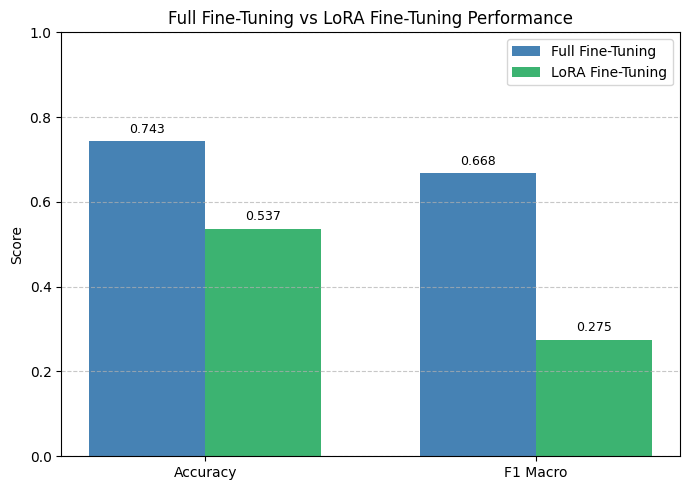

In [ ]:
# ============================================================
# 13. Comparison: Full Fine-Tuning vs LoRA (Grouped Bars)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt


acc = 0.7425
f1 = 0.6677
acc_lora = 0.5372
f1_lora = 0.2746

# Metrics
metrics = ["Accuracy", "F1 Macro"]
full_scores = [acc, f1]
lora_scores = [acc_lora, f1_lora]

x = np.arange(len(metrics))  # [0, 1] positions for Accuracy and F1
width = 0.35  # bar width

plt.figure(figsize=(7, 5))
plt.bar(x - width/2, full_scores, width, label="Full Fine-Tuning", color="steelblue")
plt.bar(x + width/2, lora_scores, width, label="LoRA Fine-Tuning", color="mediumseagreen")

# Labels and formatting
plt.xticks(x, metrics)
plt.ylabel("Score")
plt.ylim(0, 1)
plt.title("Full Fine-Tuning vs LoRA Fine-Tuning Performance")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Optional: add value annotations on each bar
for i, (full, lora) in enumerate(zip(full_scores, lora_scores)):
    plt.text(i - width/2, full + 0.02, f"{full:.3f}", ha="center", fontsize=9)
    plt.text(i + width/2, lora + 0.02, f"{lora:.3f}", ha="center", fontsize=9)

plt.tight_layout()
plt.show()



In [ ]:
acc

0.5641025641025641